#**Introduction to PyTorch: Automatic Differentiation**

In [141]:
import numpy as np
import torch
import sklearn.datasets
import matplotlib.pyplot as plt
from IPython.display import clear_output
#%matplotlib inline

In [142]:
# Create tensors
a = torch.tensor(5, dtype = torch.long)
b = torch.tensor(5, dtype = torch.int32)
b.dtype

torch.int32

Comparison with numpy:
https://github.com/torch/torch7/wiki/Torch-for-Numpy-users

In [143]:
c = torch.ones(6)
print(c, c.dtype)

tensor([1., 1., 1., 1., 1., 1.]) torch.float32


In [144]:
# Shape
c.size() #x.shape

torch.Size([6])

In [145]:
# Broadcasting
d = c + 1
print(d)

tensor([2., 2., 2., 2., 2., 2.])


In [146]:
# Change type
b.float() #b.to(torch.float)
b.dtype

torch.int32

In [147]:
# Reshape tensors
c.view(2,3)

tensor([[1., 1., 1.],
        [1., 1., 1.]])

In [148]:
# Squeeze/Unsqueeze
c.unsqueeze(dim=0).shape

torch.Size([1, 6])

In [149]:
# Dot product VS matrix multiplication

In [150]:
d.dot(c) #torch.matmul(d.T,c)

tensor(12.)

###In-place operations

The memory must be used efficiently when working with large tensors. Some operations create new object as the result of computations, others just change given object (in-place operations). In pytorch, these operations usually differ by adding an underscore:

`x.exp()   # not-in-place operation`

`x.exp_()  # in-place operation`



## Automatic Differentiation
tensor.data, tensor.grad, tensor.grad_fn
## Detaching variables

`.detach()` returns a copy of a variable, through which backpropagation doesn't pass. If you average or just store batch losses during the optimization, you'd better detach those losses before averaging or storing. Otherwise the computational graphs for each batch would be stored in memory as well as batch losses, so you run out of memory very fast.

Also there is in-place version (`.detach_()`) which doesn't create detached copy of the variable, but detach variable itself from its computational graph.

In [151]:
a = torch.rand(1, requires_grad=True)
b = torch.sin(a)

Use method tensor.backward() for b and print the derivative of b with respect to a (a.grad).

In [152]:
b.backward()
print(a.grad, torch.cos(a.data)) #zero previous value of gradients before doing calculations again

tensor([0.9133]) tensor([0.9133])


In [153]:
b = 0
b = torch.sin(a)
b.backward()
print(a.grad, torch.cos(a.data))

tensor([1.8267]) tensor([0.9133])


In [154]:
x = torch.randn(4, requires_grad=True)
y0 = torch.randn(4, requires_grad=True)
y = y0.detach() #detach gradient weights, or else it will also store all the gradients and running a second time will cause outofmemory error
z = x * y + 10 #think of as loss function
p = z.sum()
p.backward()
print('x:', x.data)
print('y:', y.data)
print('dp / dx:', x.grad)
print('dp / dy:', y.grad)

x: tensor([-0.7322,  0.3833,  1.1000, -0.0877])
y: tensor([ 0.4154,  0.6426, -2.1881,  0.8920])
dp / dx: tensor([ 0.4154,  0.6426, -2.1881,  0.8920])
dp / dy: None


##Gradient reset

In [155]:
x = torch.tensor([1, 1, 1, 1.], requires_grad=True)
y = x ** 2
p = y.sum()
p.backward()
print('x:', x)
print('dp / dx:', x.grad)
x.grad.detach_()       # extracting gradient Variable from the previous computational graph (optional)
x.grad.zero_()         # zero gradinents
y = 1 / x
p = y.sum()
p.backward()
print('x:', x)
print('dp / dx:', x.grad)

x: tensor([1., 1., 1., 1.], requires_grad=True)
dp / dx: tensor([2., 2., 2., 2.])
x: tensor([1., 1., 1., 1.], requires_grad=True)
dp / dx: tensor([-1., -1., -1., -1.])


##Leaf vs Non-leaf Variable

In [156]:
x = torch.randn(4, requires_grad=True)  # leaf variable
y = x + 1                               # not a leaf variable, calculate intermidiate derivatives
p = y.sum()                             # not a leaf variable
p.backward()
print('x:', x)
print('y:', y)
print('p:', p)
print('x.grad:', x.grad)
print('y.grad:', y.grad)
print('p.grad:', p.grad)

x: tensor([ 0.7455, -0.2460,  0.8512, -0.3502], requires_grad=True)
y: tensor([1.7455, 0.7540, 1.8512, 0.6498], grad_fn=<AddBackward0>)
p: tensor(5.0005, grad_fn=<SumBackward0>)
x.grad: tensor([1., 1., 1., 1.])
y.grad: None
p.grad: None


<ipython-input-156-1f8f6ef14d32>:9: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  print('y.grad:', y.grad)
<ipython-input-156-1f8f6ef14d32>:10: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/3053

##Gradients for non-leaf variables

In [157]:
x = torch.randn(4, requires_grad=True)   # leaf variable
z = torch.randn(4, requires_grad=True)   # leaf variable
w = z * 2      # not a leaf variable
y = x * w + 1  # forward pass before retaining gradient is ok. w is the intermidiate node
p = y.sum()

w.retain_grad() #will also calculate deravitives with respect to w

p.backward()
print('dp / dx:', x.grad)
print('dp / dz:', z.grad)
print('dp / dw:', w.grad)

dp / dx: tensor([ 3.7479, -2.7672, -1.0610, -0.8626])
dp / dz: tensor([ 3.3762, -4.3149, -2.7855, -0.7221])
dp / dw: tensor([ 1.6881, -2.1575, -1.3927, -0.3611])


## In this section, we use atomatic differentiation for the Gradient Descend

In [158]:
torch.manual_seed(0)
x = torch.linspace(1, 5, 20)
y = 2*x + 1 + 5*torch.rand(len(x))

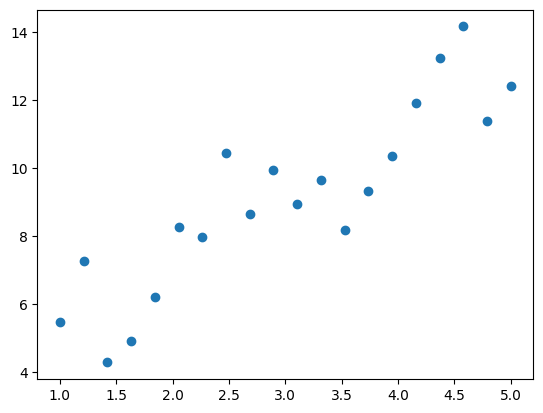

In [159]:
plt.scatter(x,y)

### Q1 (1 pt).   Initialize the weights and bais with gradients (see example with `sin(a)`).

In [160]:
w = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

In [161]:
w.data

tensor([-0.5966])

### Q2 (2pt). Write the gradient descent using automated calculation of the gradients of `w` and `b`.

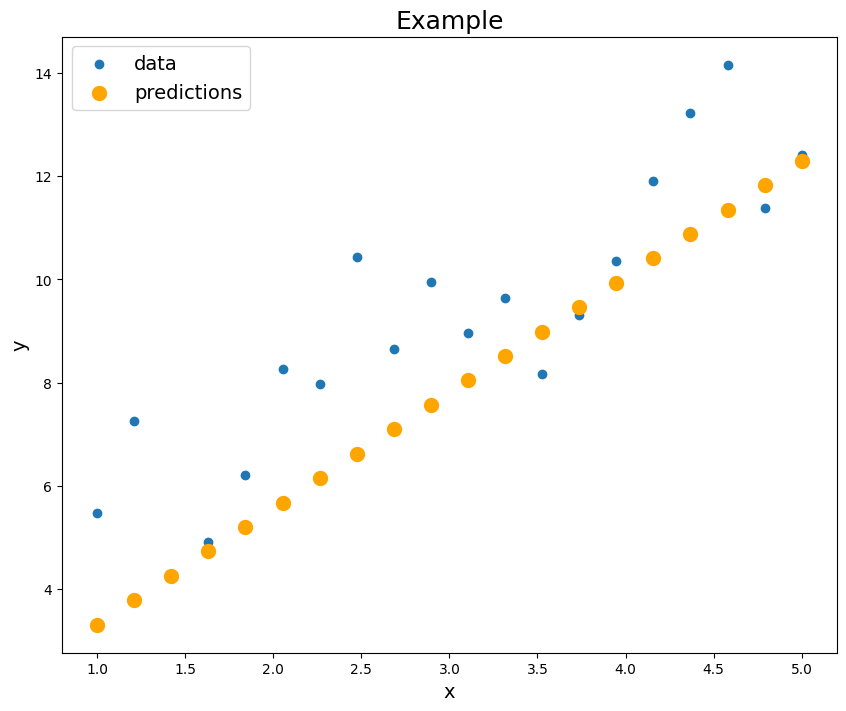

In [165]:
alpha = 0.001 #learning rate
for i in range(100):   #number of epochs
  #if the gradients are non empty, zero them:
  # if w.grad is not None:
  #   w.grad.zero_()
  #   b.grad.zero_()
  w.requires_grad_(True)
  b.requires_grad_(True)

  # calculate prediction y_p = w*x+b:
  y_p =w*x+b

  # calculate loss mean((y_p-y)**2):
  loss = torch.mean((y_p-y)**2)

  # run loss.backward() to calculate the derivatives
  loss.backward()

  # update the values of w and b, using learning rate alpha and gradients
  # w.data = w.data - alpha * w.data
  # b.data = b.data - alpha * b.data

  # or better, more elegant solution
  with torch.no_grad():
    w = w - alpha*w.grad
    b = b - alpha*b.grad

  #visualisation:
  if (i + 1) % 5 == 0:
    clear_output(True)
    plt.figure(figsize=(10,8))
    plt.scatter(x, y, label="data")
    plt.scatter(x, y_p.data.numpy(), color="orange", linewidth=5, label="predictions")
    plt.xlabel("x", fontsize=14)
    plt.ylabel("y", fontsize=14)
    plt.title("Example", fontsize=18)
    plt.legend(fontsize=14)
    plt.show()